In [88]:
import numpy as np
import matplotlib.pyplot as plt

class BernoulliBandit:
    def __init__(self, k):
        # 随机生成K个0～1的数，作为拉动每根拉杆的获奖概率
        # 默认收益为1
        self.probs = np.random.uniform(size=k)
        self.best_id = np.argmax(self.probs) # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_id] # 最大的获奖概率
        self.K = k

    def step(self, i):
        # 如果颠倒判断条件，会导致最终不收敛
        if np.random.rand() < self.probs[i]:
            return 1
        else:
            return 0

np.random.seed(2)  # 设定随机种子，使实验具有可重复性
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的是第%d号，获奖概率为%.4f" % (bandit_10_arm.best_id, bandit_10_arm.best_prob))

随机生成了一个10臂伯努利老虎机
获奖概率最大的是第7号，获奖概率为0.6193


In [89]:
class Solver:
    def __init__(self, bandit, init_prob=1.0):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K) # 每根拉杆的尝试次数
        self.estimates = np.array([init_prob] * self.bandit.K) # 初始化拉动所有拉杆的期望奖励估值，选择拉杆后，通过均值操作由得到的奖励对期望奖励进行更新
        self.regret = 0.  # 当前步的累积懊悔
        self.actions = [] # 维护一个列表，记录每一步的动作
        self.regrets = [] # 维护一个列表，记录每一步的累积懊悔

    def update_regret(self, i):
        # 计算累积懊悔并保存，k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[i]
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError

    def run(self, iters):
        # 运行一定次数,num_steps为总运行次数
        for _ in range(iters):
            i = self.run_one_step()
            self.counts[i] += 1
            self.actions.append(i)
            self.update_regret(i)


In [90]:
class EpsilonGreedy(Solver):
    """ ε-Greedy的随即探索与执行是灵魂 """
    def __init__(self, bandit, epsilon=0.01):
        super().__init__(bandit)
        self.epsilon = epsilon


    def run_one_step(self):
        if np.random.random() < self.epsilon:
            i = np.random.randint(0, self.bandit.K) # 随机选择一根拉杆
        else:
            i = np.argmax(self.estimates) # 选择期望奖励估值最大的拉杆
        r = self.bandit.step(i) # 得到本次动作的奖励
        self.estimates[i] += 1 / (self.counts[i] + 1) * (r - self.estimates[i]) # 对前面所有对该拉杆的奖励求和后，与本次的r相加再取均值。这里直接保存前面的奖励均值，
                                                                                # 即 estimates[i] = (estimates[i] * k + r) / (k+1) = estimates[i] + r - estimates[i] / (k+1) ，空间复杂度从O(n)降到了O(1)
        return i


epsilon-greedy 算法的累计懊悔为： 29.290261019181212


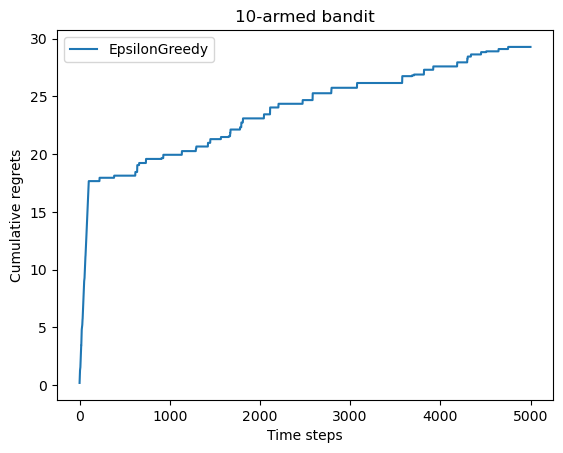

In [91]:
def plot_results(solvers, solver_names):
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(5000)
print('epsilon-greedy 算法的累计懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

epsilon-greedy-0.0001 算法的累计懊悔为1059.0744
epsilon-greedy-0.0100 算法的累计懊悔为23.7660
epsilon-greedy-0.1000 算法的累计懊悔为139.6795
epsilon-greedy-0.2500 算法的累计懊悔为482.5575
epsilon-greedy-0.5000 算法的累计懊悔为655.3069


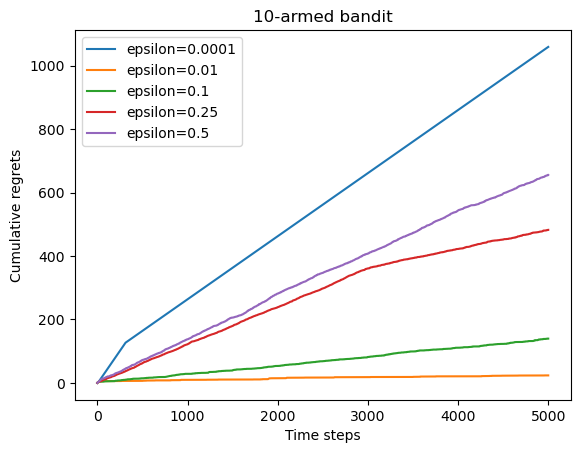

In [92]:
np.random.seed(0)
# 观察不同epsilon对贪婪算法的影响
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [
    EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons
]
epsilon_greedy_solver_names = [
    "epsilon={}".format(e) for e in epsilons
]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)
    print('epsilon-greedy-%.4f 算法的累计懊悔为%.4f' % (solver.epsilon, solver.regret))

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

In [93]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon值随时间衰减的epsilon-贪婪算法，继承Solver类 """
    def __init__(self, bandit):
        super().__init__(bandit)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count: # epsilon 随时间衰减
            i = np.random.randint(0, self.bandit.K) # 随机选择一根拉杆
        else:
            i = np.argmax(self.estimates) # 选择期望奖励估值最大的拉杆
        r = self.bandit.step(i) # 得到本次动作的奖励
        self.estimates[i] += 1 / (self.counts[i] + 1) * (r - self.estimates[i])

        return i

decaying_epsilon-greedy 算法的累计懊悔为： 6.6955552415311


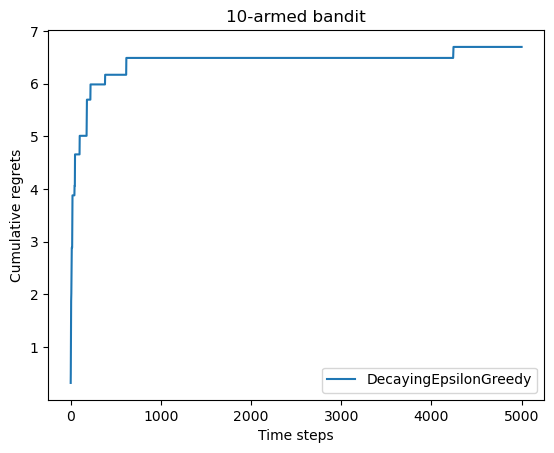

In [94]:
np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('decaying_epsilon-greedy 算法的累计懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

上置信界算法的累积懊悔为： 101.86158269134556


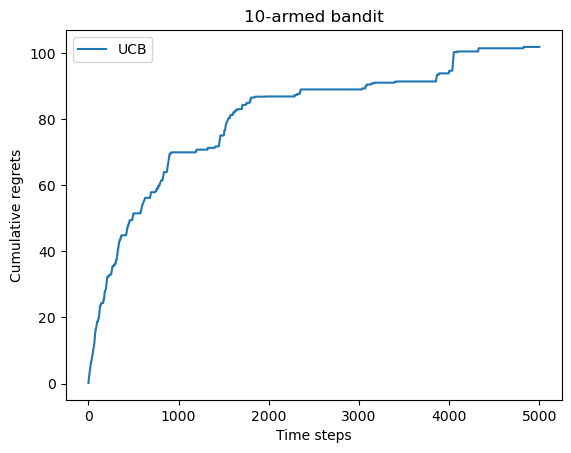

In [95]:
class UCB(Solver):
    """ 上置信度算法，基于霍夫丁不等式 """
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef

    def run_one_step(self):
        self.total_count += 1 # 类似贪婪算法，让 p = 1 / total_count，概率随次数增加而递减
        ucb = self.estimates + self.coef * np.sqrt(
            np.log(self.total_count) / (2 * (self.counts + 1)))  # 计算上置信界
        i = np.argmax(ucb)  # 选出上置信界最大的拉杆
        r = self.bandit.step(i)
        self.estimates[i] += 1 / (self.counts[i] + 1) * (r -
                                                          self.estimates[i])
        return i


np.random.seed(1)
COEF = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, COEF)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])


汤普森采样算法的累积懊悔为： 75.36199416160667


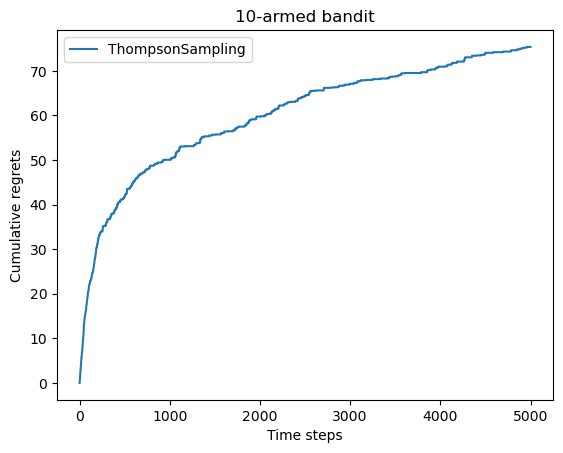

In [96]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法 根据之前的数据采样出一个概率分布 """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.zeros(self.bandit.K)  # 表示每根拉杆奖励为1的次数
        self._b = np.zeros(self.bandit.K)  # 表示每根拉杆奖励为0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a + 1, self._b + 1)  # 按照Beta分布采样一组奖励样本，令参数分别为奖励为1的次数+1、奖励为2的次数+1
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k


np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])